# Required assignment 24.2: MDPs in Python

An MDP models decision-making in environments with uncertainty. It helps agents choose actions that maximise long-term rewards.

## Key components

- **States (S)**: all possible situations the agent can be in

- **Actions (A)**: choices available to the agent in each state

- **Transition model (P)**: probability 𝑃(𝑠′∣𝑠,𝑎) of reaching state 𝑠′ from state 𝑠 by taking action 𝑎

- **Reward function (R)**: immediate reward received after transitioning to a state

- **Policy (π)**: a mapping from states to actions

- **Utility (U)** : expected long-term reward from a state, assuming optimal actions

## Maths behind MDPs

In an MDP, the utility 𝑈(𝑠) of a state tells us how good it is to be in that state — not just based on immediate reward but also based on future rewards the agent can expect if it acts optimally.

- **Utility of a state**: The utility 𝑈(𝑠) of a state is the expected sum of future rewards, assuming the agent acts optimally.

       𝑈(𝑠)=𝑅(𝑠)+ 𝛾⋅max 𝑎 ∑ 𝑠′𝑃(𝑠′∣𝑠,𝑎)⋅𝑈(𝑠′)

where

- **𝑅(𝑠)**: immediate reward for being in state 𝑠

- **𝛾**: discount factor (between 0 and 1) — it makes future rewards less important than immediate ones

- **max 𝑎** : the agent chooses the best action 𝑎

- **𝑃(𝑠′∣𝑠,𝑎)**: probability of ending up in state 𝑠′ after taking action 𝑎  in state 𝑠

- **𝑈(𝑠′)**: utility of the next state

So, the utility of a state is the immediate reward plus the best expected utility of future states, weighted by how likely each outcome is.

This is known as the **Bellman equation**.

## Example: Grid-world MDP

To make the Bellman equation more intuitive, consider a grid-world MDP:

- **Transition model**:  
  
Model $M^a_{ij} \equiv P(j|i, a) = \text{the probability that action a in state i leads to state j}$

- **Reward function**:  
  
$$
[
  R(i) =
  \begin{cases}
        -4 & \text{(nonterminal penalty)} \\
        +100 & \text{(goal; terminal)} \\
        -100 & \text{(penalty; terminal)}
  \end{cases}
]
$$

Trap (1,1): $−∞$ → unreachable

This setup encourages the agent to:

- Avoid wandering (due to the -4 penalty)

- Reach goal states quickly (+100 reward)

- Avoid traps (-100 penalty)


## Solving MDPs

In search problems (such as network routing or pathfinding), the goal is to find an optimal **sequence of actions** that leads to a goal.

In MDPs, the goal is different:  

You want to find an optimal **policy** — the best action to take in **every possible state** — because we can't predict exactly where the agent will end up.

This policy should maximise the expected utility based on the reward function \( R(i) \).

Once you compute the utility \( U(s) \) for each state, you can extract the optimal policy using maximum expected utility.

For each state, choose the action that leads to the highest expected utility
### π(s) = argmax_a ∑ P(s' | s, a) * U(s')

## Utility and maximum expected utility

In **sequential decision problems**, preferences are expressed over entire sequences of states — not just individual steps.

You usually define utility using an **additive function**:

$$
U([s_1, s_2, \dots, s_n]) = \sum_{i=1}^n R(s_i)
$$

This is similar to computing path cost in search problems.

The **utility of a single state** (also called its **value**) is:

$$
U(s_i) = \text{Sum of rewards until termination, assuming optimal actions}
$$

Once you know the utilities of all states, you can choose the best action using:

> **Maximum expected utility:**  
> Choose the action that leads to the highest expected utility of successor states.

This is the decision rule used in value iteration to extract the optimal policy. Value iteration is a method for solving MDPs by computing the utility of each state and then extracting the optimal policy.


## Value iteration update rule

The Bellman equation used in value iteration is:

$$
U(s) = R(s) + \gamma \cdot \max_a \sum_{s'} P(s' \mid s, a) \cdot U(s')
$$

In practice, this is often written more compactly as:

$$
U(i) \leftarrow R(i) + \max_a \sum_j U(j) \cdot M_{ij}^a
$$

Where:
- $M_{ij}^a $ is the probability of transitioning from state \( i \) to state \( j \) using action \( a \)
- This version assumes the transition matrix $M^a$ is known

Both forms express the same idea:  
> Update each state’s utility based on its reward and the best expected utility of future states.


In [6]:
###import necessary libraries
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from itertools import product
from matplotlib.animation import PillowWriter

### Question 1: Define the grid world

Create a 3 × 4 grid with:

- Reward of +100 at (0, 3)

- Reward of -100 at (1, 3)

- Trap at (1, 1) with reward -∞

- All other cells: reward -4

In [7]:
### GRADED CELL

grid_shape = None
grid = None
# YOUR CODE HERE
#raise NotImplementedError()

grid_shape = (3, 4)

# default reward = -4 everywhere
grid = np.full(grid_shape, -4.0)

# terminal rewards
grid[0, 3] = 100.0
grid[1, 3] = -100.0

# trap (blocked) cell
grid[1, 1] = -np.inf

print(grid)


[[  -4.   -4.   -4.  100.]
 [  -4.  -inf   -4. -100.]
 [  -4.   -4.   -4.   -4.]]


Now that you've defined the grid and assigned rewards to each cell, the next step is to model how the agent moves through this environment.

In an MDP, movement is stochastic — the agent doesn't always go exactly where it intends. For example, if it tries to move forward, it might veer left or right with some probability.

To simulate this uncertainty, you'll implement a function that returns all possible next positions and their associated probabilities, based on the agent's current heading.

## Function: `get_actions()`

This function defines the stochastic movement model:  

- 80 per cent chance of moving forward  
- 10 per cent chance of veering left  
- 10 per cent chance of veering right

In [8]:
# Direction setup
orient = east, north, west, south = [(1, 0), (0, 1), (-1, 0), (0, -1)]
turns = left, right = (+1, -1)

def turn_heading(heading, inc, headings=orient):
    return headings[(headings.index(heading) + inc) % len(headings)]

def turn_right(heading):
    return turn_heading(heading, right)

def turn_left(heading):
    return turn_heading(heading, left)

# Probabilities and action mapping
probs = (0.8, 0.1, 0.1)
assert abs(sum(probs) - 1.) <= 1.e-5

def get_actions(heading):
    actions = heading, turn_left(heading), turn_right(heading)
    return dict(zip(actions, probs))




### Question 2: Simulate agent movement

Using the helper function `get_actions()`, implement `get_moves()`.

Use the provided helper `get_actions(heading)` to get a dictionary of possible directions and their probabilities:

- 80 per cent chance of moving forward

- 10 per cent chance of veering left

- 10 per cent chance of veering right

Your function `get_moves()` should:

- Unpack the current position into x, y

- Unpack the `grid_size` into `rows`, `cols`

- Loop through each possible direction from `get_actions(head)`

For each direction:

- Compute the new position `(nx, ny)` by adding the direction to `(x, y)`

- If the new position is inside the grid and not a trap, add it to the list of moves

- Otherwise, the agent stays in place — add (x, y) with the same probability

Return a list of `((next_x, next_y), probability)` pairs.

In [10]:
###GRADED CELL
### write the code for the function get_moves(pos, head, grid_size, traps)
# YOUR CODE HERE
#raise NotImplementedError()

### GRADED CELL
### write the code for the function get_moves(pos, head, grid_size, traps)

def get_moves(pos, head, grid_size, traps=None):
    # traps should be an iterable of blocked cells, e.g. [(1,1)]
    if traps is None:
        traps = []

    x, y = pos
    ans = []

    # terminal or trap: no outgoing moves
    if is_end(pos) or is_trap(pos):
        return []

    actions = get_actions(head)  # dict: {(dx,dy): prob, ...}
    for (dx, dy), p in actions.items():
        nx, ny = x + dx, y + dy

        # if next position invalid (outside grid or into trap), stay in place
        if in_grid((nx, ny), grid_size, traps):
            ans.append(((nx, ny), p))
        else:
            ans.append(((x, y), p))

    return ans



To support value iteration, define helper functions that identify traps, terminal states and valid grid positions.


In [11]:

traps = ((1, 1),)
ends = ((0,3), (1, 3),)

def at_landmark(pos, landmarks):
    return any([pos == a for a in landmarks])

is_end = lambda pos: at_landmark(pos, ends)

is_trap = lambda pos: at_landmark(pos, traps)

def in_grid(pos, grid_size, traps):
    # unpacking values
    tall, wide = grid_size
    x, y = pos
    valid_x = (0 <= x < tall)
    valid_y = (0 <= y < wide)
    return valid_x and valid_y and not is_trap(pos)

Before you compute utilities, recap how the agent moves:

- **Directions**: east, north, west and south
- **Turning**: left/right
- **Movement is stochastic**: 80 per cent forward, 10 per cent left and 10 per cent right

In [12]:
orient = east, north, west, south = [(1, 0), (0, 1), (-1, 0), (0, -1)]

turns = left, right = (+1, -1)

def turn_heading(heading, inc, headings=orient):
    return headings[(headings.index(heading) + inc) % len(headings)]

def turn_right(heading):
    return turn_heading(heading, right)

def turn_left(heading):
    return turn_heading(heading, left)

turn_left((1, 0))

(0, 1)

In [13]:
probs = (0.8, 0.1, 0.1)
assert abs(sum(probs) - 1.) <= 1.e-5

def get_actions(heading):
    actions = heading, turn_left(heading), turn_right(heading)
    return dict(zip(actions, probs))
get_actions((1, 0))

{(1, 0): 0.8, (0, 1): 0.1, (0, -1): 0.1}

In [14]:
def get_moves(pos, head, grid_size, traps=traps):
    # unpacking values
    tall, wide = grid_size
    x, y = pos
    ans = []
    possible_actions = ()
    if is_end(pos):
        return []
    if is_trap(pos):
        return []
    else:
        actions = get_actions(head)
        for (dx, dy), p in actions.items():
            _x = x + dx
            _y = y + dy
            if in_grid((_x, _y), grid_size, traps):
                ans.append(((_x, _y), p))
            else:
                ans.append(((x, y), p))
        return ans

res = get_moves(pos=(0, 0), head=west, grid_size=grid.shape)
print('starting from (0, 0):', res)
# can move right or left with 10% chance but will stay put with 80% chance
assert res == [((0, 0), 0.8), ((0, 0), 0.1), ((0, 1), 0.1)]

starting from (0, 0): [((0, 0), 0.8), ((0, 0), 0.1), ((0, 1), 0.1)]


You've already implemented the movement logic and defined the grid. Now look at how value iteration computes the utility of each state using the Bellman update.

Below is the value iteration function.

## Value iteration overview

In value iteration, ypu update each state's utility using the Bellman equation:



$$
U(s) = R(s) + \gamma \cdot \max_a \sum_{s'} P(s'|s,a) \cdot U(s')
$$



The algorithm:
1. Initialises utility values
2. Iteratively updates each state using the Bellman update
3. Stops when changes fall below a threshold

Now, answer the question below based on this logic.


In [15]:
def value_iteration(grid, gamma=0.9, epsilon=1e-3, max_iter=1000):
    R = grid.copy()
    U = grid.copy()
    U_hist = []

    def utility_update(pos):
        utils = []
        for h in orient:
            moves = get_moves(pos, h, grid.shape, traps=((1, 1),))
            util_h = sum([U.item(s) * prob for s, prob in moves])
            utils.append(util_h)
        return R.item(pos) + gamma * max(utils)

    tall, wide = grid.shape
    thold = epsilon * (1 - gamma) / gamma

    for _ in range(max_iter):
        _U = np.empty(grid.shape)
        for pos in product(*map(range, grid.shape)):
            if not np.isfinite(R[pos]):
                _U[pos] = R[pos]
            else:
                _U[pos] = utility_update(pos)
        finite_mask = np.isfinite(_U) & np.isfinite(U)
        delta = np.max(np.abs(_U[finite_mask] - U[finite_mask]))

        U = _U
        U_hist.append((_, U.copy()))
        if delta < thold:
            break

    return U_hist


In [16]:


def plot_utilities(U):
    fig, ax = plt.subplots()
    ax.axis('off')
    img = ax.imshow(U, cmap=plt.get_cmap("viridis"))
    cbar = fig.colorbar(img)

    # Overlay utility values
    for (i, j), z in np.ndenumerate(U):
        if np.isfinite(z):
            ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', color='white')

    plt.title("Final Utility Values")
    plt.show()


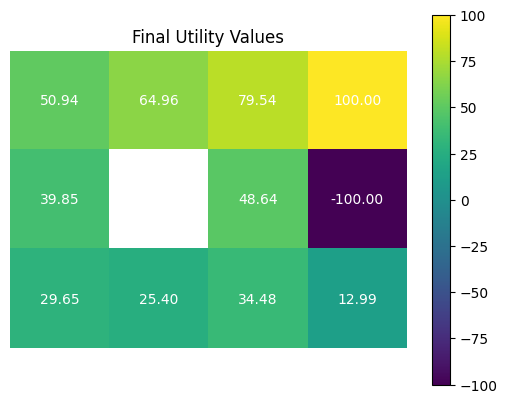

In [17]:
U_hist = value_iteration(grid)
plot_utilities(U_hist[-1][1])  # Call this after value_iteration


### Question 3:

What does the function `utility_update(pos)` compute?

a. The immediate reward at `pos`

b. The average utility of all neighbouring states

c. The maximum expected utility from `pos` based on possible actions

d. The discounted reward for reaching a terminal state

Set your answer to `ans3` by selecting one of a,b,c and d.

In [18]:
### GRADED CELL
ans3 = None
# YOUR CODE HERE
#raise NotImplementedError()

### GRADED CELL
ans3 = "c"


In **Question 3**, you explored how value iteration computes the utility of each state in a grid-world MDP. By applying the Bellman update repeatedly, the agent learns which states are more desirable based on long-term rewards.

Now that you've generated a sequence of utility grids (`U_hist`), it's time to **visualise the final result**.

You visualise because

- It helps you **see convergence** — how utility values stabilise over time.
- It reveals how **rewards and traps influence planning**.
- It prepares you to interpret policies and agent behaviour in future tasks.

---




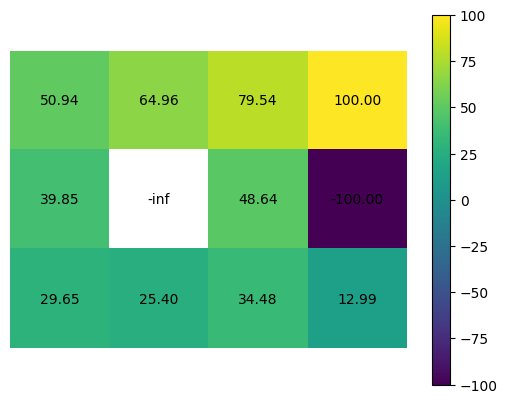

In [19]:

plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

fig, ax = plt.subplots()
ax.axis('off')
img = ax.imshow(U_hist[0][1], cmap=plt.get_cmap("viridis"), animated=True)
cbar = fig.colorbar(img)

def animate(i):
    img.set_array(U_hist[i][1])
    return img,

anim = animation.FuncAnimation(fig, animate,
                               frames=len(U_hist),
                               interval=20,
                               blit=True,
                               repeat=True)

# Save with PillowWriter explicitly
writer = PillowWriter(fps=4)
anim.save('grid_animation_final.gif', writer=writer)

# https://stackoverflow.com/questions/20998083/show-the-values-in-the-grid-using-matplotlib
data = U_hist[-1][1]
for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
plt.show()

### Question 4: 

What is the purpose of the animation created using `U_hist`?

a. To visualise the agent’s movement path through the grid

b. To show how the reward function changes over time

c. To illustrate how utility values evolve during value iteration

d. To display the transition probabilities between grid cells

Set your answer to `ans4` by selecting one of a,b,c and d.

In [20]:
### GRADED CELL
ans4 = None
# YOUR CODE HERE
#raise NotImplementedError()

### GRADED CELL
ans4 = "c"


In this assignment, you implemented and solved a grid-based MDP using value iteration. Through this, you learned to compute utilities, simulate stochastic movement and visualise how optimal decisions emerge over time.